In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import scipy
import warnings

import sklearn
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.model_selection import RepeatedKFold, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.cross_decomposition import CCA, PLSCanonical
from sklearn.utils import Bunch

rs_num = 14
rng = np.random.default_rng(rs_num)

sklearn.set_config(display="diagram")

# 1. Dataset Construction

In [2]:
sample_num = 300
X_dimension_num = 4
Y_dimension_num = 3

# construct X
x1 = rng.normal(loc=0.0, scale=1.0, size=(sample_num, 1))
x2 = rng.normal(loc=0.0, scale=1.0, size=(sample_num, 1))
x3 = rng.normal(loc=0.0, scale=1.0, size=(sample_num, 1))
x4 = rng.normal(loc=0.0, scale=1.0, size=(sample_num, 1))

X = np.zeros((sample_num, X_dimension_num))
X[:, 0] = x1.reshape(-1, )
X[:, 1] = x2.reshape(-1, )
X[:, 2] = x3.reshape(-1, )
X[:, 3] = x4.reshape(-1, )

# noise
xi_1 = rng.normal(loc=0, scale=np.sqrt(0.2), size=x3.shape)
xi_2 = rng.normal(loc=0, scale=np.sqrt(0.4), size=x1.shape)
xi_3 = rng.normal(loc=0, scale=np.sqrt(0.3), size=x4.shape)

# contruct Y
y1 = x3 + xi_1
y2 = x1 + xi_2
y3 = -x4 + xi_3

Y = np.zeros((sample_num, Y_dimension_num))
Y[:, 0] = y1.reshape(-1, )
Y[:, 1] = y2.reshape(-1, )
Y[:, 2] = y3.reshape(-1, )

We can also check out the correlation between X and Y:

In [3]:
# customized
def custom_abs_corr_viz(ax, corr_coef):
    im = ax.imshow(np.abs(corr_coef))
    cbar = ax.figure.colorbar(im, ax=ax)
    for i in range(corr_coef.shape[0]):
        for j in range(corr_coef.shape[1]):
            text = ax.text(
                j, i, format(np.abs(corr_coef)[i, j], '.2f'), 
                ha="center", va="center", color="w"
            )

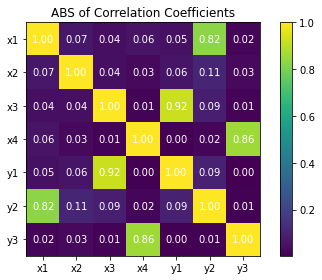

In [4]:
corr_coef = np.corrcoef(X.T, Y.T)
corr_labels = (
    ['x'+str(i+1) for i in range(X_dimension_num)] + 
    ['y'+str(i+1) for i in range(Y_dimension_num)]
)

fig, ax = plt.subplots(figsize=(6, 4))

custom_abs_corr_viz(ax, corr_coef)

ax.set_xticks(np.arange(len(corr_labels)), labels=corr_labels)
ax.set_yticks(np.arange(len(corr_labels)), labels=corr_labels)
ax.set_title('ABS of Correlation Coefficients')

plt.tight_layout()

Split the dataset into training and testing datasets:

In [5]:
[X_train, X_test, Y_train, Y_test] = train_test_split(X, Y, test_size=0.20, random_state=rs_num)

Standardize two matrices:

In [6]:
# standardization of two matrices
X_train_scaler = StandardScaler().fit(X_train)
X_train_standardized = X_train_scaler.transform(X_train)
X_test_standardized = X_train_scaler.transform(X_test)

Y_train_scaler = StandardScaler().fit(Y_train)
Y_train_standardized = Y_train_scaler.transform(Y_train)
Y_test_standardized = Y_train_scaler.transform(Y_test)

We can also get a baseline model evaluation through linear regression.

In [7]:
baseline_bunch = Bunch()
baseline_bunch.name = 'baseline'

baseline_bunch.pipeline = Pipeline(
    [
        ('scaler', StandardScaler()), 
        ('lr', LinearRegression())
    ]
)

baseline_bunch.cv_scores = cross_validate(
    baseline_bunch.pipeline, X_train, Y_train, 
    cv=RepeatedKFold(n_splits=5, n_repeats=5, random_state=rs_num)
)['test_score']

# also train on the whole training dataset, and see the score on the test dataset
baseline_bunch.pipeline.fit(X_train, Y_train)

# modal evaluation on the test dataset
baseline_bunch.eval_score = baseline_bunch.pipeline.score(X_test, Y_test)

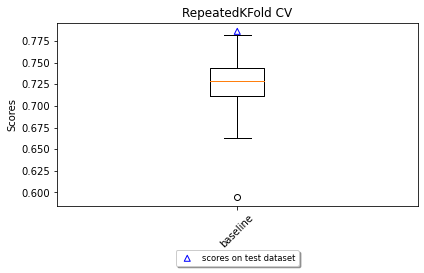

In [8]:
# put everything in one list
bunch_list = [baseline_bunch]

# visualize model evaluation
viz_labels = []
viz_boxplots = []
viz_eval_scores = []
viz_eval_scores_pos = []

for i, bunch in enumerate(bunch_list):
    viz_labels.append(bunch.name)
    viz_boxplots.append(bunch.cv_scores)
    viz_eval_scores.append(bunch.eval_score)
    viz_eval_scores_pos.append(i+1)

# visualization
fig, ax = plt.subplots()

ax.boxplot(
    viz_boxplots, labels=viz_labels
)
ax.scatter(
    viz_eval_scores_pos, 
    viz_eval_scores, 
    fc='none',
    ec='blue', 
    marker='^', 
    label='scores on test dataset'
)

ax.set(ylabel='Scores', title='RepeatedKFold CV')
ax.set_xticklabels(viz_labels, rotation=45)
ax.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, -0.22),
    fancybox=True,
    shadow=True,
    ncol=2,
    fontsize='small'
)

plt.tight_layout()

# 2. CCA via sklearn CCA

In [9]:
# create a customized cross-validation method
def custom_cv(validator, X, Y, fit_n_score_func, *args):
    # note: normally X and Y are already training datasets
    
    # construct score array
    score_arr = np.zeros((validator.get_n_splits(), ))
    
    # fit and validate
    ii = 0
    for train_ind, test_ind in validator.split(X):
        # slicing arrays
        X_train, X_test = X[train_ind], X[test_ind]
        Y_train, Y_test = Y[train_ind], Y[test_ind]
        
        # train the model and get the score
        score_arr[ii] = fit_n_score_func(X_train, X_test, Y_train, Y_test, *args)
        ii += 1
    
    return score_arr

In [10]:
# create a customized pipeline
def sklearn_cca_fit_n_score(X_train, X_test, Y_train, Y_test, n_components, max_iter, tol):
    # fitting the model
    cca = CCA(n_components=n_components, max_iter=max_iter, tol=tol).fit(X_train, Y_train)
    
    # transform the model
    Xc_train, Yc_train = cca.transform(X_train, Y_train)
    Xc_test, Yc_test = cca.transform(X_test, Y_test)
    
    # train with linear regression and get a score
    return LinearRegression().fit(Xc_train, Yc_train).score(Xc_test, Yc_test)

In [11]:
sklearn_bunch = Bunch()
sklearn_bunch.name = 'sklearn'

In [12]:
sklearn_bunch.rkf = RepeatedKFold(n_splits=5, n_repeats=5, random_state=rs_num)
sklearn_bunch.n_components = np.min([X_dimension_num, Y_dimension_num])
sklearn_bunch.max_iter = int(1e12)
sklearn_bunch.tol = 1e-12

In [13]:
# manuallly chain them together
sklearn_bunch.cca = CCA(
    n_components=sklearn_bunch.n_components, 
    max_iter=sklearn_bunch.max_iter, 
    tol=sklearn_bunch.tol
).fit(X_train, Y_train)

# note: X and Y will be standardized
[sklearn_bunch.Xc_train, 
 sklearn_bunch.Yc_train] = sklearn_bunch.cca.transform(X_train, Y_train)
[sklearn_bunch.Xc_test, 
 sklearn_bunch.Yc_test] = sklearn_bunch.cca.transform(X_test, Y_test)

# calculate canonical correlation
sklearn_bunch.cc = np.corrcoef(
    sklearn_bunch.Xc_train.T, sklearn_bunch.Yc_train.T
).diagonal(offset=sklearn_bunch.n_components)

# also compare if pre-standardization would make a difference
[sklearn_bunch.check_Xc_train, 
 sklearn_bunch.check_Yc_train] = CCA(
    n_components=sklearn_bunch.n_components, 
    max_iter=sklearn_bunch.max_iter, 
    tol=sklearn_bunch.tol
).fit_transform(X_train_standardized, Y_train_standardized)

print(
    'Pre-standardization makes {:.2e} total difference on X'.format(
        np.linalg.norm(
            sklearn_bunch.check_Xc_train - sklearn_bunch.Xc_train
        )
    )
)
print(
    'Pre-standardization makes {:.2e} total difference on Y'.format(
        np.linalg.norm(
            sklearn_bunch.check_Yc_train - sklearn_bunch.Yc_train
        )
    )
)

Pre-standardization makes 8.20e-14 total difference on X
Pre-standardization makes 8.18e-14 total difference on Y


We can also see how the correlation in the transformed matrices:

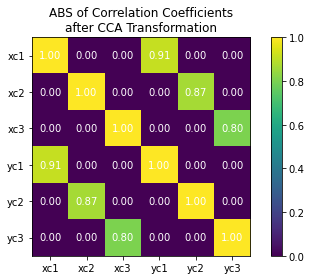

In [14]:
corr_coef = np.corrcoef(sklearn_bunch.Xc_train.T, sklearn_bunch.Yc_train.T)
corr_labels = (
    ['xc'+str(i+1) for i in range(sklearn_bunch.Xc_train.shape[1])] + 
    ['yc'+str(i+1) for i in range(sklearn_bunch.Yc_train.shape[1])]
)

fig, ax = plt.subplots(figsize=(6, 4))

custom_abs_corr_viz(ax, corr_coef)

ax.set_xticks(np.arange(len(corr_labels)), labels=corr_labels)
ax.set_yticks(np.arange(len(corr_labels)), labels=corr_labels)
ax.set_title('ABS of Correlation Coefficients\nafter CCA Transformation')

plt.tight_layout()

Now we can similarly apply the same Linear Regression on the transformed datasets.

In [15]:
sklearn_bunch.cv_scores = custom_cv(
    sklearn_bunch.rkf, X_train, Y_train, 
    sklearn_cca_fit_n_score, 
    sklearn_bunch.n_components, 
    sklearn_bunch.max_iter, 
    sklearn_bunch.tol
)

# also evaluate them manually
sklearn_bunch.eval_score = sklearn_cca_fit_n_score(
    X_train, X_test, Y_train, Y_test, 
    sklearn_bunch.n_components, sklearn_bunch.max_iter, sklearn_bunch.tol
)

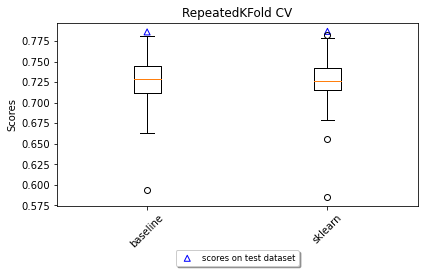

In [16]:
# put everything in one list
bunch_list = [baseline_bunch, sklearn_bunch]

# visualize model evaluation
viz_labels = []
viz_boxplots = []
viz_eval_scores = []
viz_eval_scores_pos = []

for i, bunch in enumerate(bunch_list):
    viz_labels.append(bunch.name)
    viz_boxplots.append(bunch.cv_scores)
    viz_eval_scores.append(bunch.eval_score)
    viz_eval_scores_pos.append(i+1)

# visualization
fig, ax = plt.subplots()

ax.boxplot(
    viz_boxplots, 
    labels=viz_labels
)
ax.scatter(
    viz_eval_scores_pos, 
    viz_eval_scores,  
    fc='none',
    ec='blue', 
    marker='^', 
    label='scores on test dataset'
)

ax.set(ylabel='Scores', title='RepeatedKFold CV')
ax.set_xticklabels(viz_labels, rotation=45)
ax.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, -0.22),
    fancybox=True,
    shadow=True,
    ncol=2,
    fontsize='small'
)

plt.tight_layout()

# 3. CCA via Standard Eigenvalue Problem

In [17]:
# compute joint covariance matrix
C = np.cov(X_train_standardized.T, Y_train_standardized.T, ddof=0)

Cxx = C[0:X_dimension_num, 0:X_dimension_num]
Cxy = C[0:X_dimension_num, X_dimension_num:]
Cyy = C[X_dimension_num:, X_dimension_num:]

C_compute = np.linalg.multi_dot(
    [np.linalg.inv(Cyy), Cxy.T, np.linalg.inv(Cxx), Cxy]
)

In [18]:
# standard eigenvalue problem
std_eig_bunch = Bunch()
std_eig_bunch.name = 'std eig'

# solve eig
[std_eig_bunch.eig_val, 
 std_eig_bunch.eig_vec] = np.linalg.eig(C_compute)

# Y matrix weights
std_eig_bunch.wy = std_eig_bunch.eig_vec

std_eig_bunch.cc_arr = np.sqrt(std_eig_bunch.eig_val)
print('The canonical correlation is:')
print(std_eig_bunch.cc_arr)

# X matrix weights
std_eig_bunch.wx = np.linalg.multi_dot(
    [np.linalg.inv(Cxx), Cxy, std_eig_bunch.wy]
)/std_eig_bunch.cc_arr

The canonical correlation is:
[0.91048651 0.80452823 0.86642529]


In [19]:
# sort by canonical correlation
sort_ind = std_eig_bunch.cc_arr.argsort()
std_eig_bunch.cc_arr_sorted = std_eig_bunch.cc_arr[sort_ind[::-1]]
std_eig_bunch.wx_sorted = std_eig_bunch.wx[:, sort_ind[::-1]]
std_eig_bunch.wy_sorted = std_eig_bunch.wy[:, sort_ind[::-1]]

del sort_ind

In [20]:
print('Canonical Correlation calculated by Standard Eigenvalue Problem:')
print(std_eig_bunch.cc_arr_sorted)
print('')
print('Canonical Correlation calculated by sklearn CCA:')
print(sklearn_bunch.cc)

Canonical Correlation calculated by Standard Eigenvalue Problem:
[0.91048651 0.86642529 0.80452823]

Canonical Correlation calculated by sklearn CCA:
[0.91048651 0.86642529 0.80452823]


In [21]:
print('Weight vector w_x calculated by Standard Eigenvalue Problem:')
print(std_eig_bunch.wx_sorted)
print('')
print('Weight vector w_x calculated by sklearn CCA:')
print(sklearn_bunch.cca.x_weights_)

Weight vector w_x calculated by Standard Eigenvalue Problem:
[[-0.10185969 -0.23970984  0.93366329]
 [ 0.04420503  0.01218802 -0.07242301]
 [-0.99097395  0.18065651 -0.14774114]
 [-0.09693603 -0.93487307 -0.3524133 ]]

Weight vector w_x calculated by sklearn CCA:
[[ 0.10166669  0.2512014   0.95903829]
 [-0.04412212 -0.01529023 -0.07699841]
 [ 0.98911949 -0.12042806 -0.07641433]
 [ 0.09674585  0.96029222 -0.26168234]]


In [22]:
print('Weight vector w_y calculated by Standard Eigenvalue Problem:')
print(std_eig_bunch.wy_sorted)
print('')
print('Weight vector w_y calculated by sklearn CCA:')
print(sklearn_bunch.cca.y_weights_)

Weight vector w_y calculated by Standard Eigenvalue Problem:
[[-0.98695911  0.1985678  -0.18571926]
 [-0.11429969 -0.26796202  0.93281165]
 [ 0.11334591  0.9427445   0.3088216 ]]

Weight vector w_y calculated by sklearn CCA:
[[ 0.98696035 -0.14106983 -0.077515  ]
 [ 0.11429728  0.27512491  0.95459018]
 [-0.11333757 -0.95100241  0.28766127]]


Now we can see how well this method handles the datasets.

In [23]:
# create a customized pipeline
def std_eig_cca_fit_n_score(X_train, X_test, Y_train, Y_test, n_components):
    X_dimension_num = X_train.shape[1]
    
    # standardization of two matrices
    X_train_scaler = StandardScaler().fit(X_train)
    X_train_standardized = X_train_scaler.transform(X_train)
    X_test_standardized = X_train_scaler.transform(X_test)

    Y_train_scaler = StandardScaler().fit(Y_train)
    Y_train_standardized = Y_train_scaler.transform(Y_train)
    Y_test_standardized = Y_train_scaler.transform(Y_test)
    
    # compute joint covariance matrix
    C = np.cov(X_train_standardized.T, Y_train_standardized.T, ddof=0)

    Cxx = C[0:X_dimension_num, 0:X_dimension_num]
    Cxy = C[0:X_dimension_num, X_dimension_num:]
    Cyy = C[X_dimension_num:, X_dimension_num:]

    C_compute = np.linalg.multi_dot(
        [np.linalg.inv(Cyy), Cxy.T, np.linalg.inv(Cxx), Cxy]
    )
    
    # solve standard eigenvalue problem
    [eig_val, eig_vec] = np.linalg.eig(C_compute)
    
    # canonical correlation values
    cc_arr = np.sqrt(eig_val)

    # matrices weights
    wy = eig_vec
    wx = np.linalg.multi_dot([np.linalg.inv(Cxx), Cxy, wy])/cc_arr
    
    # sort by canonical correlation
    cc_argind = cc_arr.argsort()
    cc_arr_sorted = cc_arr[cc_argind[::-1]]
    wx_sorted = wx[:, cc_argind[::-1]]
    wy_sorted = wy[:, cc_argind[::-1]]
    
    # transform matrices
    Xc_train = X_train_standardized.dot(wx_sorted)[:, :n_components]
    Xc_test = X_test_standardized.dot(wx_sorted)[:, :n_components]
    Yc_train = Y_train_standardized.dot(wy_sorted)[:, :n_components]
    Yc_test = Y_test_standardized.dot(wy_sorted)[:, :n_components]
    
    # train with linear regression and get a score
    return LinearRegression().fit(Xc_train, Yc_train).score(Xc_test, Yc_test)

In [24]:
std_eig_bunch.rkf = RepeatedKFold(n_splits=5, n_repeats=5, random_state=rs_num)
std_eig_bunch.n_components = sklearn_bunch.n_components

In [25]:
# cross-validate
std_eig_bunch.cv_scores = custom_cv(
    std_eig_bunch.rkf, X_train, Y_train, 
    std_eig_cca_fit_n_score, 
    std_eig_bunch.n_components
)

# also evaluate them manually
std_eig_bunch.eval_score = std_eig_cca_fit_n_score(
    X_train, X_test, Y_train, Y_test, 
    std_eig_bunch.n_components
)

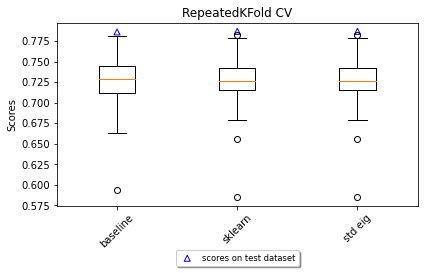

In [26]:
# put everything in one list
bunch_list = [
    baseline_bunch, 
    sklearn_bunch, 
    std_eig_bunch
]

# visualize model evaluation
viz_labels = []
viz_boxplots = []
viz_eval_scores = []
viz_eval_scores_pos = []

for i, bunch in enumerate(bunch_list):
    viz_labels.append(bunch.name)
    viz_boxplots.append(bunch.cv_scores)
    viz_eval_scores.append(bunch.eval_score)
    viz_eval_scores_pos.append(i+1)

# visualization
fig, ax = plt.subplots()

ax.boxplot(
    viz_boxplots, 
    labels=viz_labels
)
ax.scatter(
    viz_eval_scores_pos, 
    viz_eval_scores, 
    fc='none',
    ec='blue', 
    marker='^', 
    label='scores on test dataset'
)

ax.set(ylabel='Scores', title='RepeatedKFold CV')
ax.set_xticklabels(viz_labels, rotation=45)
ax.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, -0.22),
    fancybox=True,
    shadow=True,
    ncol=2,
    fontsize='small'
)

plt.tight_layout()

# 4. CCA via Generalized Eigenvalue Problem

In [27]:
gen_eig_bunch = Bunch()
gen_eig_bunch.name = 'gen eig'

In [28]:
# construct general matrices
gen_eig_bunch.A = np.zeros(
    (
        X_dimension_num+Y_dimension_num, 
        X_dimension_num+Y_dimension_num
    )
)
gen_eig_bunch.A[:X_dimension_num, X_dimension_num:] = Cxy
gen_eig_bunch.A[X_dimension_num:, :X_dimension_num] = Cxy.T

gen_eig_bunch.B = np.zeros_like(gen_eig_bunch.A)
gen_eig_bunch.B[:X_dimension_num, :X_dimension_num] = Cxx
gen_eig_bunch.B[X_dimension_num:, X_dimension_num:] = Cyy

# solve generalized eigenvalue problem
[gen_eig_bunch.eig_val, 
 gen_eig_bunch.eig_vec] = scipy.linalg.eigh(gen_eig_bunch.A, gen_eig_bunch.B)

# retrive canonical correlation and weight vectors
gen_eig_bunch.cc_arr = gen_eig_bunch.eig_val[gen_eig_bunch.eig_val>=1e-6]
gen_eig_bunch.eig_vec_positive = gen_eig_bunch.eig_vec[:, gen_eig_bunch.eig_val>=1e-6]

# sort out w.r.t. cc values
sort_ind = gen_eig_bunch.cc_arr.argsort()
gen_eig_bunch.cc_arr_sorted = gen_eig_bunch.cc_arr[sort_ind[::-1]]
gen_eig_bunch.eig_vec_positive_sorted = gen_eig_bunch.eig_vec_positive[:, sort_ind[::-1]]
gen_eig_bunch.wx_sorted = gen_eig_bunch.eig_vec_positive_sorted[:X_dimension_num, :]
gen_eig_bunch.wy_sorted = gen_eig_bunch.eig_vec_positive_sorted[X_dimension_num:, :]

del sort_ind

Check out results v.s. other methods

In [29]:
print('Canonical Correlation calculated by Generalized Eigenvalue Problem:')
print(gen_eig_bunch.cc_arr_sorted)
print('')
print('Canonical Correlation calculated by Standard Eigenvalue Problem:')
print(std_eig_bunch.cc_arr_sorted)
print('')
print('Canonical Correlation calculated by sklearn CCA:')
print(sklearn_bunch.cc)

Canonical Correlation calculated by Generalized Eigenvalue Problem:
[0.91048651 0.86642529 0.80452823]

Canonical Correlation calculated by Standard Eigenvalue Problem:
[0.91048651 0.86642529 0.80452823]

Canonical Correlation calculated by sklearn CCA:
[0.91048651 0.86642529 0.80452823]


In [30]:
print('Weight vector w_x calculated by Generalized Eigenvalue Problem:')
print(gen_eig_bunch.wx_sorted)
print('')
print('Weight vector w_x calculated by Standard Eigenvalue Problem:')
print(std_eig_bunch.wx_sorted)
print('')
print('Weight vector w_x calculated by sklearn CCA:')
print(sklearn_bunch.cca.x_weights_)

Weight vector w_x calculated by Generalized Eigenvalue Problem:
[[-0.07078271 -0.16939328  0.68419364]
 [ 0.03071825  0.00861278 -0.05307199]
 [-0.68863183  0.12766267 -0.10826553]
 [-0.06736124 -0.6606371  -0.25825042]]

Weight vector w_x calculated by Standard Eigenvalue Problem:
[[-0.10185969 -0.23970984  0.93366329]
 [ 0.04420503  0.01218802 -0.07242301]
 [-0.99097395  0.18065651 -0.14774114]
 [-0.09693603 -0.93487307 -0.3524133 ]]

Weight vector w_x calculated by sklearn CCA:
[[ 0.10166669  0.2512014   0.95903829]
 [-0.04412212 -0.01529023 -0.07699841]
 [ 0.98911949 -0.12042806 -0.07641433]
 [ 0.09674585  0.96029222 -0.26168234]]


In [31]:
print('Weight vector w_y calculated by Generalized Eigenvalue Problem:')
print(gen_eig_bunch.wy_sorted)
print('')
print('Weight vector w_y calculated by Standard Eigenvalue Problem:')
print(std_eig_bunch.wy_sorted)
print('')
print('Weight vector w_y calculated by sklearn CCA:')
print(sklearn_bunch.cca.y_weights_)

Weight vector w_y calculated by Generalized Eigenvalue Problem:
[[-0.6858419   0.14031986 -0.1360961 ]
 [-0.07942732 -0.18935795  0.68356954]
 [ 0.07876453  0.66619952  0.22630618]]

Weight vector w_y calculated by Standard Eigenvalue Problem:
[[-0.98695911  0.1985678  -0.18571926]
 [-0.11429969 -0.26796202  0.93281165]
 [ 0.11334591  0.9427445   0.3088216 ]]

Weight vector w_y calculated by sklearn CCA:
[[ 0.98696035 -0.14106983 -0.077515  ]
 [ 0.11429728  0.27512491  0.95459018]
 [-0.11333757 -0.95100241  0.28766127]]


The differences over eigenvectors are caused by the numerical ways of solving the generalized eigenvalue problem.

Now we can evaluate the model.

In [32]:
def gen_eig_cca_fit_n_score(X_train, X_test, Y_train, Y_test, n_components):
    X_dimension_num = X_train.shape[1]
    Y_dimension_num = Y_train.shape[1]
    
    # standardization of two matrices
    X_train_scaler = StandardScaler().fit(X_train)
    X_train_standardized = X_train_scaler.transform(X_train)
    X_test_standardized = X_train_scaler.transform(X_test)

    Y_train_scaler = StandardScaler().fit(Y_train)
    Y_train_standardized = Y_train_scaler.transform(Y_train)
    Y_test_standardized = Y_train_scaler.transform(Y_test)
    
    # compute joint covariance matrix
    C = np.cov(X_train_standardized.T, Y_train_standardized.T, ddof=0)

    Cxx = C[0:X_dimension_num, 0:X_dimension_num]
    Cxy = C[0:X_dimension_num, X_dimension_num:]
    Cyy = C[X_dimension_num:, X_dimension_num:]
    
    # construct general matrices
    A = np.zeros(
        (
            X_dimension_num+Y_dimension_num, 
            X_dimension_num+Y_dimension_num
        )
    )
    A[:X_dimension_num, X_dimension_num:] = Cxy
    A[X_dimension_num:, :X_dimension_num] = Cxy.T

    B = np.zeros_like(A)
    B[:X_dimension_num, :X_dimension_num] = Cxx
    B[X_dimension_num:, X_dimension_num:] = Cyy
    
    # solve generalized eigenvalue problem
    [eig_val, eig_vec] = scipy.linalg.eigh(A, B)

    # retrive canonical correlation and weight vectors
    cc_arr = eig_val[eig_val>=1e-6]
    eig_vec_positive = eig_vec[:, eig_val>=1e-6]
    
    # sort out w.r.t. cc values
    sort_ind = cc_arr.argsort()
    cc_arr_sorted = cc_arr[sort_ind[::-1]]
    eig_vec_positive_sorted = eig_vec_positive[:, sort_ind[::-1]]
    wx_sorted = eig_vec_positive_sorted[:X_dimension_num, :]
    wy_sorted = eig_vec_positive_sorted[X_dimension_num:, :]
    
    # transform matrices
    Xc_train = X_train_standardized.dot(wx_sorted)[:, :n_components]
    Xc_test = X_test_standardized.dot(wx_sorted)[:, :n_components]
    Yc_train = Y_train_standardized.dot(wy_sorted)[:, :n_components]
    Yc_test = Y_test_standardized.dot(wy_sorted)[:, :n_components]
    
    # train with linear regression and get a score
    return LinearRegression().fit(Xc_train, Yc_train).score(Xc_test, Yc_test)

In [33]:
gen_eig_bunch.rkf = RepeatedKFold(n_splits=5, n_repeats=5, random_state=rs_num)
gen_eig_bunch.n_components = sklearn_bunch.n_components

In [34]:
# cross-validate
gen_eig_bunch.cv_scores = custom_cv(
    gen_eig_bunch.rkf, X_train, Y_train, 
    gen_eig_cca_fit_n_score, 
    gen_eig_bunch.n_components
)

# also evaluate them manually
gen_eig_bunch.eval_score = gen_eig_cca_fit_n_score(
    X_train, X_test, Y_train, Y_test, 
    gen_eig_bunch.n_components
)

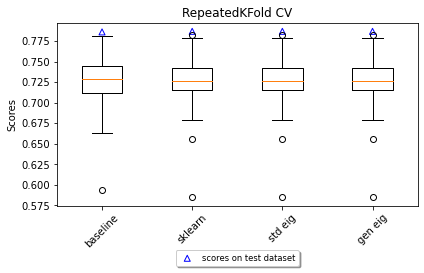

In [35]:
# put everything in one list
bunch_list = [
    baseline_bunch, 
    sklearn_bunch, 
    std_eig_bunch, 
    gen_eig_bunch
]

# visualize model evaluation
viz_labels = []
viz_boxplots = []
viz_eval_scores = []
viz_eval_scores_pos = []

for i, bunch in enumerate(bunch_list):
    viz_labels.append(bunch.name)
    viz_boxplots.append(bunch.cv_scores)
    viz_eval_scores.append(bunch.eval_score)
    viz_eval_scores_pos.append(i+1)

# visualization
fig, ax = plt.subplots()

ax.boxplot(
    viz_boxplots, 
    labels=viz_labels
)
ax.scatter(
    viz_eval_scores_pos, 
    viz_eval_scores, 
    fc='none',
    ec='blue', 
    marker='^', 
    label='scores on test dataset'
)

ax.set(ylabel='Scores', title='RepeatedKFold CV')
ax.set_xticklabels(viz_labels, rotation=45)
ax.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, -0.22),
    fancybox=True,
    shadow=True,
    ncol=2,
    fontsize='small'
)

plt.tight_layout()

# 5. CCA via SVD

In [36]:
svd_bunch = Bunch()
svd_bunch.name = 'svd'

In [37]:
svd_bunch.Cxx_sqrt_inv = scipy.linalg.inv(
    scipy.linalg.cholesky(Cxx, lower=True)
) # lower Cholesky decomposition
svd_bunch.Cyy_sqrt_inv = scipy.linalg.inv(
    scipy.linalg.cholesky(Cyy, lower=True)
)
svd_bunch.mat_to_svd = np.linalg.multi_dot(
    [svd_bunch.Cxx_sqrt_inv, Cxy, svd_bunch.Cyy_sqrt_inv]
) # matrix to SVD

# SVD decomposition
[svd_bunch.U, 
 svd_bunch.cc_arr_sorted, 
 svd_bunch.Vh] = scipy.linalg.svd(
    svd_bunch.mat_to_svd, full_matrices=False
)

# compute weights vectors
svd_bunch.wx_sorted = np.matmul(svd_bunch.Cxx_sqrt_inv, svd_bunch.U)
svd_bunch.wy_sorted = np.matmul(svd_bunch.Cyy_sqrt_inv, svd_bunch.Vh.T)

We can compare the Canonical Correlation and Weights with other methods.

In [38]:
print('Canonical Correlation calculated by SVD:')
print(svd_bunch.cc_arr_sorted)
print('')
print('Canonical Correlation calculated by Generalized Eigenvalue Problem:')
print(gen_eig_bunch.cc_arr_sorted)
print('')
print('Canonical Correlation calculated by Standard Eigenvalue Problem:')
print(std_eig_bunch.cc_arr_sorted)
print('')
print('Canonical Correlation calculated by sklearn CCA:')
print(sklearn_bunch.cc)

Canonical Correlation calculated by SVD:
[0.9035447  0.86807943 0.80916449]

Canonical Correlation calculated by Generalized Eigenvalue Problem:
[0.91048651 0.86642529 0.80452823]

Canonical Correlation calculated by Standard Eigenvalue Problem:
[0.91048651 0.86642529 0.80452823]

Canonical Correlation calculated by sklearn CCA:
[0.91048651 0.86642529 0.80452823]


In [39]:
print('Weight vector w_x calculated by SVD:')
print(svd_bunch.wx_sorted)
print('')
print('Weight vector w_x calculated by Generalized Eigenvalue Problem:')
print(gen_eig_bunch.wx_sorted)
print('')
print('Weight vector w_x calculated by Standard Eigenvalue Problem:')
print(std_eig_bunch.wx_sorted)
print('')
print('Weight vector w_x calculated by sklearn CCA:')
print(sklearn_bunch.cca.x_weights_)

Weight vector w_x calculated by SVD:
[[ 0.24042349  0.35517808 -0.89966837]
 [-0.07237315  0.03315146 -0.00493191]
 [ 0.93665464 -0.25040306  0.25543699]
 [ 0.08981333  0.8770094   0.50251745]]

Weight vector w_x calculated by Generalized Eigenvalue Problem:
[[-0.07078271 -0.16939328  0.68419364]
 [ 0.03071825  0.00861278 -0.05307199]
 [-0.68863183  0.12766267 -0.10826553]
 [-0.06736124 -0.6606371  -0.25825042]]

Weight vector w_x calculated by Standard Eigenvalue Problem:
[[-0.10185969 -0.23970984  0.93366329]
 [ 0.04420503  0.01218802 -0.07242301]
 [-0.99097395  0.18065651 -0.14774114]
 [-0.09693603 -0.93487307 -0.3524133 ]]

Weight vector w_x calculated by sklearn CCA:
[[ 0.10166669  0.2512014   0.95903829]
 [-0.04412212 -0.01529023 -0.07699841]
 [ 0.98911949 -0.12042806 -0.07641433]
 [ 0.09674585  0.96029222 -0.26168234]]


In [40]:
print('Weight vector w_y calculated by SVD:')
print(svd_bunch.wy_sorted)
print('')
print('Weight vector w_y calculated by Generalized Eigenvalue Problem:')
print(gen_eig_bunch.wy_sorted)
print('')
print('Weight vector w_y calculated by Standard Eigenvalue Problem:')
print(std_eig_bunch.wy_sorted)
print('')
print('Weight vector w_y calculated by sklearn CCA:')
print(sklearn_bunch.cca.y_weights_)

Weight vector w_y calculated by SVD:
[[ 0.94407807 -0.25728229  0.20620966]
 [ 0.15241502  0.29376259 -0.96137308]
 [-0.15696027 -0.925324   -0.35199577]]

Weight vector w_y calculated by Generalized Eigenvalue Problem:
[[-0.6858419   0.14031986 -0.1360961 ]
 [-0.07942732 -0.18935795  0.68356954]
 [ 0.07876453  0.66619952  0.22630618]]

Weight vector w_y calculated by Standard Eigenvalue Problem:
[[-0.98695911  0.1985678  -0.18571926]
 [-0.11429969 -0.26796202  0.93281165]
 [ 0.11334591  0.9427445   0.3088216 ]]

Weight vector w_y calculated by sklearn CCA:
[[ 0.98696035 -0.14106983 -0.077515  ]
 [ 0.11429728  0.27512491  0.95459018]
 [-0.11333757 -0.95100241  0.28766127]]


The differences are pretty significant. But we can also check out how the model performs.

In [41]:
def svd_cca_fit_n_score(X_train, X_test, Y_train, Y_test, n_components):
    X_dimension_num = X_train.shape[1]
    Y_dimension_num = Y_train.shape[1]
    
    # standardization of two matrices
    X_train_scaler = StandardScaler().fit(X_train)
    X_train_standardized = X_train_scaler.transform(X_train)
    X_test_standardized = X_train_scaler.transform(X_test)

    Y_train_scaler = StandardScaler().fit(Y_train)
    Y_train_standardized = Y_train_scaler.transform(Y_train)
    Y_test_standardized = Y_train_scaler.transform(Y_test)
    
    # compute joint covariance matrix
    C = np.cov(X_train_standardized.T, Y_train_standardized.T, ddof=0)

    Cxx = C[0:X_dimension_num, 0:X_dimension_num]
    Cxy = C[0:X_dimension_num, X_dimension_num:]
    Cyy = C[X_dimension_num:, X_dimension_num:]
    
    
    Cxx_sqrt_inv = scipy.linalg.inv(
        scipy.linalg.cholesky(Cxx, lower=True)
    ) # lower Cholesky decomposition
    Cyy_sqrt_inv = scipy.linalg.inv(
        scipy.linalg.cholesky(Cyy, lower=True)
    )
    mat_to_svd = np.linalg.multi_dot(
        [Cxx_sqrt_inv, Cxy, Cyy_sqrt_inv]
    ) # matrix to SVD

    # SVD decomposition
    [U, cc_arr_sorted, Vh] = scipy.linalg.svd(
        mat_to_svd, full_matrices=False
    )

    # compute weights vectors
    wx_sorted = np.matmul(Cxx_sqrt_inv, U)
    wy_sorted = np.matmul(Cyy_sqrt_inv, Vh.T)
    
    # transform matrices
    Xc_train = X_train_standardized.dot(wx_sorted)[:, :n_components]
    Xc_test = X_test_standardized.dot(wx_sorted)[:, :n_components]
    Yc_train = Y_train_standardized.dot(wy_sorted)[:, :n_components]
    Yc_test = Y_test_standardized.dot(wy_sorted)[:, :n_components]
    
    # train with linear regression and get a score
    return LinearRegression().fit(Xc_train, Yc_train).score(Xc_test, Yc_test)

In [42]:
svd_bunch.rkf = RepeatedKFold(n_splits=5, n_repeats=5, random_state=rs_num)
svd_bunch.n_components = sklearn_bunch.n_components

In [43]:
# cross-validate
svd_bunch.cv_scores = custom_cv(
    svd_bunch.rkf, X_train, Y_train, 
    svd_cca_fit_n_score, 
    svd_bunch.n_components
)

# also evaluate them manually
svd_bunch.eval_score = svd_cca_fit_n_score(
    X_train, X_test, Y_train, Y_test, 
    svd_bunch.n_components
)

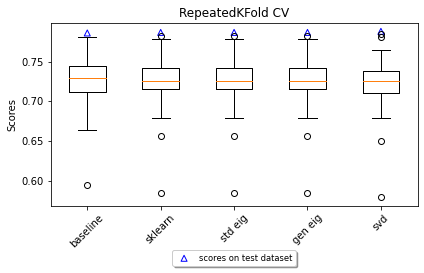

In [44]:
# put everything in one list
bunch_list = [
    baseline_bunch, 
    sklearn_bunch, 
    std_eig_bunch, 
    gen_eig_bunch, 
    svd_bunch
]

# visualize model evaluation
viz_labels = []
viz_boxplots = []
viz_eval_scores = []
viz_eval_scores_pos = []

for i, bunch in enumerate(bunch_list):
    viz_labels.append(bunch.name)
    viz_boxplots.append(bunch.cv_scores)
    viz_eval_scores.append(bunch.eval_score)
    viz_eval_scores_pos.append(i+1)

# visualization
fig, ax = plt.subplots()

ax.boxplot(
    viz_boxplots, 
    labels=viz_labels
)
ax.scatter(
    viz_eval_scores_pos, 
    viz_eval_scores, 
    fc='none',
    ec='blue', 
    marker='^', 
    label='scores on test dataset'
)

ax.set(ylabel='Scores', title='RepeatedKFold CV')
ax.set_xticklabels(viz_labels, rotation=45)
ax.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, -0.22),
    fancybox=True,
    shadow=True,
    ncol=2,
    fontsize='small'
)

plt.tight_layout()

Although the CC and Weights are different, SVD method still provides similar performance.